In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import os as os
os.getcwd()

'/content'

In [3]:
cd /content/drive/MyDrive/Lab6

/content/drive/MyDrive/Lab6


#​ Block 1: Setup and Dependencies

In [4]:
# Install dependencies
#!pip install timm torch torchvision matplotlib numpy tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import timm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy
from typing import Dict, List, Optional, Tuple, Union, Any
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Timm version: {timm.__version__}")


Using device: cuda
PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
Timm version: 1.0.22


# Block 2: Data Loading and Calibration Setup

In [5]:
# CIFAR-10 data preparation
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Create calibration subset (512 samples)
calibration_indices = np.random.choice(len(trainset), 512, replace=False)
calibration_set = Subset(trainset, calibration_indices)
calibration_loader = DataLoader(calibration_set, batch_size=32, shuffle=False)

# Test loader
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

print(f"Calibration samples: {len(calibration_set)}")
print(f"Test samples: {len(testset)}")


100%|██████████| 170M/170M [00:03<00:00, 42.7MB/s]


Calibration samples: 512
Test samples: 10000


# Block 3: Load ViT-S Model

In [6]:
# Load pretrained ViT-S model
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=10)
model = model.to(device)
model.eval()

print(f"Model: {model.__class__.__name__}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Model: VisionTransformer
Total parameters: 21,669,514


# Block 4: Fine-Tuning and Baseline Evaluation (UPDATED)

FINE-TUNING ViT-S ON CIFAR-10


Epoch 1/3: 100%|██████████| 782/782 [08:04<00:00,  1.61it/s, loss=0.0085, acc=95.08%]


Epoch 1/3 - Train Loss: 0.1527, Train Acc: 95.08%, Test Acc: 96.25%, Best Acc: 96.25%


Epoch 2/3: 100%|██████████| 782/782 [08:03<00:00,  1.62it/s, loss=0.0048, acc=98.15%]


Epoch 2/3 - Train Loss: 0.0543, Train Acc: 98.15%, Test Acc: 96.93%, Best Acc: 96.93%


Epoch 3/3: 100%|██████████| 782/782 [08:04<00:00,  1.62it/s, loss=0.0285, acc=99.51%]


Epoch 3/3 - Train Loss: 0.0157, Train Acc: 99.51%, Test Acc: 98.13%, Best Acc: 98.13%

Fine-tuning completed! Best accuracy: 98.13%
Best model saved to: ./best_vit_cifar10.pth
Loaded best model from epoch 3

Evaluating fine-tuned FP32 baseline...


Evaluating: 100%|██████████| 157/157 [00:49<00:00,  3.20it/s]


FP32 Fine-tuned - Accuracy: 98.13%, Avg Latency: 0.0072s


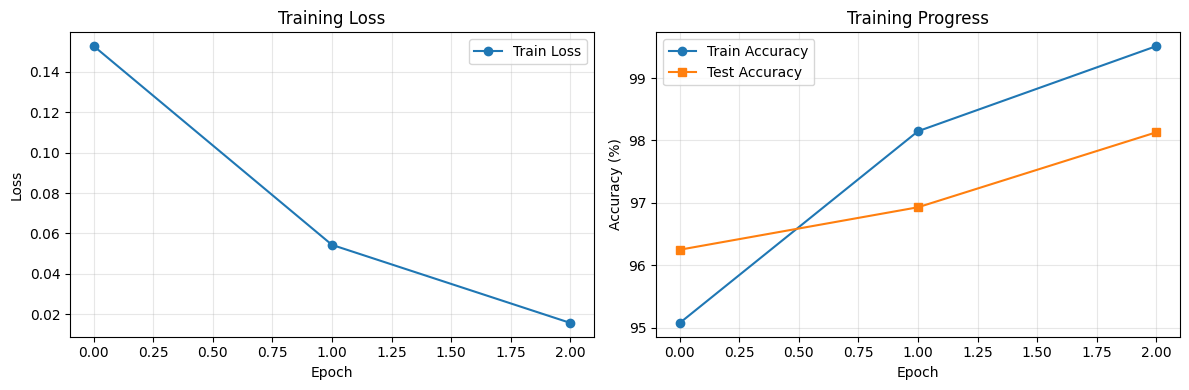

Training history plot saved to: ./training_history.png
Final model saved to: ./vit_s_cifar10_final.pth


In [8]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import os

def train_model(model, train_loader, test_loader, device, epochs=10, lr=1e-4):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    best_accuracy = 0.0
    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total

        # Update learning rate
        scheduler.step()

        # Save best model
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': test_acc,
            }, './best_vit_cifar10.pth')

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, "
              f"Test Acc: {test_acc:.2f}%, "
              f"Best Acc: {best_accuracy:.2f}%")

    return model, best_accuracy, history

def evaluate_model(model, dataloader, device):
    """Evaluate model accuracy"""
    model.eval()
    correct = 0
    total = 0
    inference_time = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            start_time = time.time()
            outputs = model(images)
            inference_time += time.time() - start_time

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_latency = inference_time / len(dataloader)

    return accuracy, avg_latency, inference_time

# Fine-tune the model
print("="*70)
print("FINE-TUNING ViT-S ON CIFAR-10")
print("="*70)

# Create training loader
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

############### Write here #############
# Fine-tune
fine_tuned_model, best_acc, training_history = train_model(
    model, train_loader, test_loader, device, epochs=3, lr=1e-4
)

print(f"\nFine-tuning completed! Best accuracy: {best_acc:.2f}%")
print(f"Best model saved to: ./best_vit_cifar10.pth")

# Load best model for evaluation
checkpoint = torch.load('./best_vit_cifar10.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate fine-tuned model
print("\nEvaluating fine-tuned FP32 baseline...")
fp32_accuracy, fp32_latency, fp32_time = evaluate_model(model, test_loader, device)
print(f"FP32 Fine-tuned - Accuracy: {fp32_accuracy:.2f}%, Avg Latency: {fp32_latency:.4f}s")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_history['train_loss'], label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(training_history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(training_history['test_acc'], label='Test Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to: ./training_history.png")

# Save final model with complete information
torch.save({
    'model_state_dict': model.state_dict(),
    'accuracy': fp32_accuracy,
    'model_config': {
        'name': 'vit_small_patch16_224',
        'num_classes': 10,
        'dataset': 'CIFAR-10'
    },
    'training_history': training_history
}, './vit_s_cifar10_final.pth')

print(f"Final model saved to: ./vit_s_cifar10_final.pth")

In [9]:
# Print model structure before smoothing
print("=== Structure BEFORE Smoothing ===")
print(model)


=== Structure BEFORE Smoothing ===
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (d

# Block 5: SmoothQuant Core - Activation Statistics Collection (UPDATED)

In [18]:
class ActivationCollector:

    def __init__(self) -> None:
        self.activations = {}
        self.hooks = []

    def register_hooks(self, model) -> None:
        for name, module in model.named_modules():
            # 我們只關心 Linear Layer
            if isinstance(module, nn.Linear):
                # [修正重點] 這裡要呼叫 _get_hook，而不是 hook_fn
                hook = module.register_forward_hook(
                    self._get_hook(name)
                )
                self.hooks.append(hook)

    def _get_hook(self, name):
        def hook(modul: nn.Module, input: Tuple[torch.Tensor, ...], output:torch.Tensor):
            # Record max absolute values per input channel
            x = input[0].detach()

            if x.dim() == 3:
                x = x.reshape(-1, x.size(-1))
            elif x.dim() == 2:
                pass
            else:
                return

            # 計算該 Linear 層每個 input channel 的最大絕對值
            channel_max = torch.abs(x).max(dim=0)[0]

            if name not in self.activations:
                self.activations[name] = channel_max
            else:
                self.activations[name] = torch.max(
                    self.activations[name], channel_max
                )
        return hook

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []


#Block 6: SmoothQuant - Compute Smoothing Factors

In [11]:
def compute_smoothing_factors(model, activation_stats, alpha=0.5):

    smoothing_factors = {}

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and name in activation_stats:

            # 1. Get activation max per channel
            # act_max 形狀應為 [in_features]
            act_max = activation_stats[name].to(device)

            # 2. Get weight max per input channel
            # module.weight 形狀: [out_features, in_features]
            # 我們要找每個 input channel (直行) 的最大值，所以對 dim=0 取 max
            weight_max = module.weight.abs().max(dim=0)[0].to(device)

            # 3. Compute smoothing factor
            # 避免除以 0，可以加上一個極小值 (1e-5)
            # 公式: s = (max(|X|)^alpha) / (max(|W|)^(1-alpha))
            act_pow = act_max.pow(alpha)
            weight_pow = weight_max.pow(1 - alpha)

            # 加上 clamp 避免數值不穩定
            s = act_pow / (weight_pow + 1e-5)

            # (選用) 有些實作會在這裡做 clip，例如限制 s 在 [1e-2, 1e2] 之間

            smoothing_factors[name] = s.to(device)

    return smoothing_factors


#Block 7: SmoothQuant - Apply Smoothing Transformation

In [12]:
@torch.no_grad()
def smooth_ln_fcs(ln, fc, scales):

    if not isinstance(fc, nn.Linear) or not isinstance(ln, (nn.LayerNorm, nn.Embedding)):
        print(f"Warning: Skipping smoothing, layers not match: {type(ln)}, {type(fc)}")
        return

    ########### Write here ############
    # scales 形狀: [in_features]

        # 1. Smooth the Activation Source (LayerNorm)
        # LayerNorm 的參數形狀也是 [in_features]，直接除即可
        ln.weight.div_(scales)
        ln.bias.div_(scales)

        # 2. Smooth the Weights (Linear Layer)
        # Linear Weight 形狀: [out_features, in_features]
        # Scales 形狀: [in_features]
        # 為了讓每個 input channel (column) 都能乘到對應的 scale，我們需要 reshape
        # view(1, -1) 變成 [1, in_features]，利用廣播機制 (Broadcasting)
        fc.weight.mul_(scales.view(1, -1))


    # Note: Linear's bias does not need modification, because (X/s) * (W*s) + b = XW + b


In [13]:
def apply_smooth_quant_vit(model, smoothing_factors):

    print("Applying SmoothQuant fusion (LN -> Linear)...")

    blocks = model.blocks if hasattr(model, 'blocks') else model.encoder.layers

    for i, block in enumerate(blocks):

        # Process Attention's QKV (Norm1 -> QKV)
        qkv_key = f"blocks.{i}.attn.qkv"
        if qkv_key in smoothing_factors:
            scales = smoothing_factors[qkv_key]
            # Pass LayerNorm (norm1) and Linear (qkv)
            smooth_ln_fcs(block.norm1, block.attn.qkv, scales)

        # Process FC1 (Norm2 -> FC1)
        fc1_key = f"blocks.{i}.mlp.fc1"
        if fc1_key in smoothing_factors:
            scales = smoothing_factors[fc1_key]
            # Pass LayerNorm (norm2) and Linear (fc1)
            smooth_ln_fcs(block.norm2, block.mlp.fc1, scales)

        # Skip FC2
        # Because FC2 does not have LN before it

    print("Fusion complete. LayerNorms and Linear weights have been updated.")
    return model


#Block 8: Quantization Functions

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def quantize_weight_per_channel(w, n_bits=8):
    ############ Write here ##############
    # w shape: [out_features, in_features]

    # 2. calculate q_max (例如 8-bit 就是 127)
    q_max = 2**(n_bits - 1) - 1

    # 1. calculate scales
    # Per-Channel (Output Channel): 對 dim=1 取 max (保留維度以便廣播)
    # 這樣每個 output channel 會有一個 scale
    scales = w.abs().max(dim=1, keepdim=True)[0] / q_max

    # 3. clamp the scales (避免 scale 過小)
    scales = scales.clamp(min=1e-5)

    # 4. Quantize: 除以 scale -> round -> clamp -> 轉整數
    t_quant = (w / scales).round().clamp(-q_max, q_max).to(torch.int8)

    # 5. Dequantize: 乘回 scale (模擬推論時的數值)
    w_dequant = t_quant * scales

    return w_dequant

def quantize_activation_dynamic_per_token(t, n_bits=8):

    ############ Write here ##############
    # 2. calculate q_max (先算最大整數範圍，8-bit 為 127)
    q_max = 2**(n_bits - 1) - 1

    # 1. calculate scales
    # t 的形狀通常是 [Batch, Tokens, Channels] 或 [N, C]
    # 我們要對最後一個維度 (Channels) 取絕對值的最大值
    # keepdim=True 很重要，這樣維度才會是 [N, 1]，才能跟原始資料相除
    scales = t.abs().max(dim=-1, keepdim=True)[0] / q_max

    # 3. clamp the scales
    # 避免 scale 太小導致除法數值爆炸，設定一個極小值下限
    scales = scales.clamp(min=1e-5)

    # 4. Quantize (量化)
    # 公式：round(t / scale) -> clamp 限制範圍 -> 轉成整數 (模擬)
    t_quant = (t / scales).round().clamp(-q_max, q_max)

    # 5. Dequantize (反量化)
    # 為了在 FP32 模型中模擬量化效果，我們要把整數乘回 scale 變回浮點數
    t_dequant = t_quant * scales

    return t_dequant


In [15]:
class QuantizedLinear(nn.Module):
    def __init__(self, original_layer, n_bits=8):

        super().__init__()
        self.in_features = original_layer.in_features
        self.out_features = original_layer.out_features
        self.n_bits = n_bits

        # Weights are statically quantized
        with torch.no_grad():
            self.weight = nn.Parameter(
                quantize_weight_per_channel(original_layer.weight.data, n_bits),
                requires_grad=False
            )

            if original_layer.bias is not None:
                self.bias = nn.Parameter(original_layer.bias.data.clone(), requires_grad=False)
            else:
                self.register_parameter('bias', None)

    def forward(self, x):

        # Call dynamic quantization function
        x_q = quantize_activation_dynamic_per_token(x, self.n_bits)

        return F.linear(x_q, self.weight, self.bias)


In [16]:
def quantize_model_dynamic(model, n_bits=8):
    quantized_model = copy.deepcopy(model)
    for name, module in quantized_model.named_modules():
        if isinstance(module, nn.Linear):

            quant_linear = QuantizedLinear(module, n_bits=n_bits)

            parent_name = '.'.join(name.split('.')[:-1])
            child_name = name.split('.')[-1]
            if parent_name:
                parent = quantized_model.get_submodule(parent_name)
            else:
                parent = quantized_model
            setattr(parent, child_name, quant_linear)
    return quantized_model


# Block 9 : Application Place

In [19]:
print("\n" + "="*70)
print("COLLECTING ACTIVATION STATISTICS (Fine-tuned Model)")
print("="*70)
collector = ActivationCollector()
collector.register_hooks(model)

model.eval()
with torch.no_grad():
    for images, _ in tqdm(calibration_loader, desc="Calibration"):
        images = images.to(device)
        _ = model(images)

collector.remove_hooks()
activation_stats = collector.activations
print(f"Collected statistics for {len(activation_stats)} linear layers")


COLLECTING ACTIVATION STATISTICS (Fine-tuned Model)


Calibration: 100%|██████████| 16/16 [00:01<00:00,  8.81it/s]

Collected statistics for 49 linear layers


In [20]:
smoothing_factors = compute_smoothing_factors(model, activation_stats, alpha=0.5)
smoothed_model = copy.deepcopy(model)

# Smooth
print("Applying SmoothQuant Fusion...")
apply_smooth_quant_vit(smoothed_model, smoothing_factors)

# Fake Quant
print("Quantizing Model (Dynamic)...")
quantized_model = quantize_model_dynamic(smoothed_model, n_bits=8)
quantized_model = quantized_model.to(device)

print("Dynamic Quantization complete!")


Applying SmoothQuant Fusion...
Applying SmoothQuant fusion (LN -> Linear)...
Fusion complete. LayerNorms and Linear weights have been updated.
Quantizing Model (Dynamic)...
Dynamic Quantization complete!


In [21]:
print("=== Structure After Smoothing and Quantize ===")
print(quantized_model)

=== Structure After Smoothing and Quantize ===
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): QuantizedLinear()
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): QuantizedLinear()
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): QuantizedLinear()
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): QuantizedLinear(

# Block 9: Evaluate Quantized Model

In [23]:
print("\n" + "="*70)
print("EVALUATING QUANTIZED MODEL")
print("="*70)

alpha = 0.5

quant_accuracy, quant_latency, quant_time = evaluate_model(
    quantized_model, test_loader, device
)
print(f"W8A8 SmoothQuant - Accuracy: {quant_accuracy:.2f}%, Avg Latency: {quant_latency:.4f}s")

# Save quantized model
torch.save({
    'model_state_dict': quantized_model.state_dict(),
    'smoothing_factors': smoothing_factors,
    'alpha': alpha,
    'accuracy': quant_accuracy,
    'model_config': {
        'name': 'vit_small_patch16_224',
        'num_classes': 10,
        'dataset': 'CIFAR-10',
        'quantization': 'W8A8'
    }
}, './vit_s_quantized_cifar10.pth')
print(f"Quantized model saved to: ./vit_s_quantized_cifar10.pth")



EVALUATING QUANTIZED MODEL


Evaluating: 100%|██████████| 157/157 [00:58<00:00,  2.70it/s]


W8A8 SmoothQuant - Accuracy: 98.16%, Avg Latency: 0.0154s
Quantized model saved to: ./vit_s_quantized_cifar10.pth


# Block 10: Benchmark Results Table

In [24]:
print("\n" + "="*70)
print("BENCHMARK RESULTS - CIFAR-10 (Fine-tuned Model)")
print("="*70)
print(f"{'Method':<30} {'Accuracy (%)':<15} {'Latency (s)':<15} {'Total Time (s)':<15}")
print("-"*70)
print(f"{'FP32 Fine-tuned':<30} {fp32_accuracy:<15.2f} {fp32_latency:<15.4f} {fp32_time:<15.2f}")
print(f"{'W8A8 SmoothQuant':<30} {quant_accuracy:<15.2f} {quant_latency:<15.4f} {quant_time:<15.2f}")
print("-"*70)
print(f"{'Accuracy Delta':<30} {quant_accuracy - fp32_accuracy:<15.2f}")
print(f"{'Speedup':<30} {fp32_time / quant_time:<15.2f}x")
print("="*70)

# Calculate memory savings
fp32_size = sum(p.numel() * 4 for p in model.parameters()) / (1024**2)  # MB
int8_size = sum(p.numel() for p in quantized_model.parameters()) / (1024**2)
print(f"\nModel Size - FP32: {fp32_size:.2f} MB")
print(f"Model Size - INT8: {int8_size:.2f} MB (approx)")
print(f"Memory Reduction: {fp32_size / int8_size:.2f}x")

# Save benchmark results
benchmark_results = {
    'fp32': {'accuracy': fp32_accuracy, 'latency': fp32_latency, 'time': fp32_time},
    'w8a8_smoothquant': {'accuracy': quant_accuracy, 'latency': quant_latency, 'time': quant_time},
    'alpha': alpha,
    'model_size_mb': {'fp32': fp32_size, 'int8': int8_size}
}

import json
with open('./benchmark_results.json', 'w') as f:
    json.dump(benchmark_results, f, indent=4)

print(f"\nBenchmark results saved to: ./benchmark_results.json")



BENCHMARK RESULTS - CIFAR-10 (Fine-tuned Model)
Method                         Accuracy (%)    Latency (s)     Total Time (s) 
----------------------------------------------------------------------
FP32 Fine-tuned                98.13           0.0072          1.13           
W8A8 SmoothQuant               98.16           0.0154          2.41           
----------------------------------------------------------------------
Accuracy Delta                 0.03           
Speedup                        0.47           x

Model Size - FP32: 82.66 MB
Model Size - INT8: 20.67 MB (approx)
Memory Reduction: 4.00x

Benchmark results saved to: ./benchmark_results.json


# Block 11 : Comparison Graph

>>> PLOT: WEIGHT BEFORE/AFTER


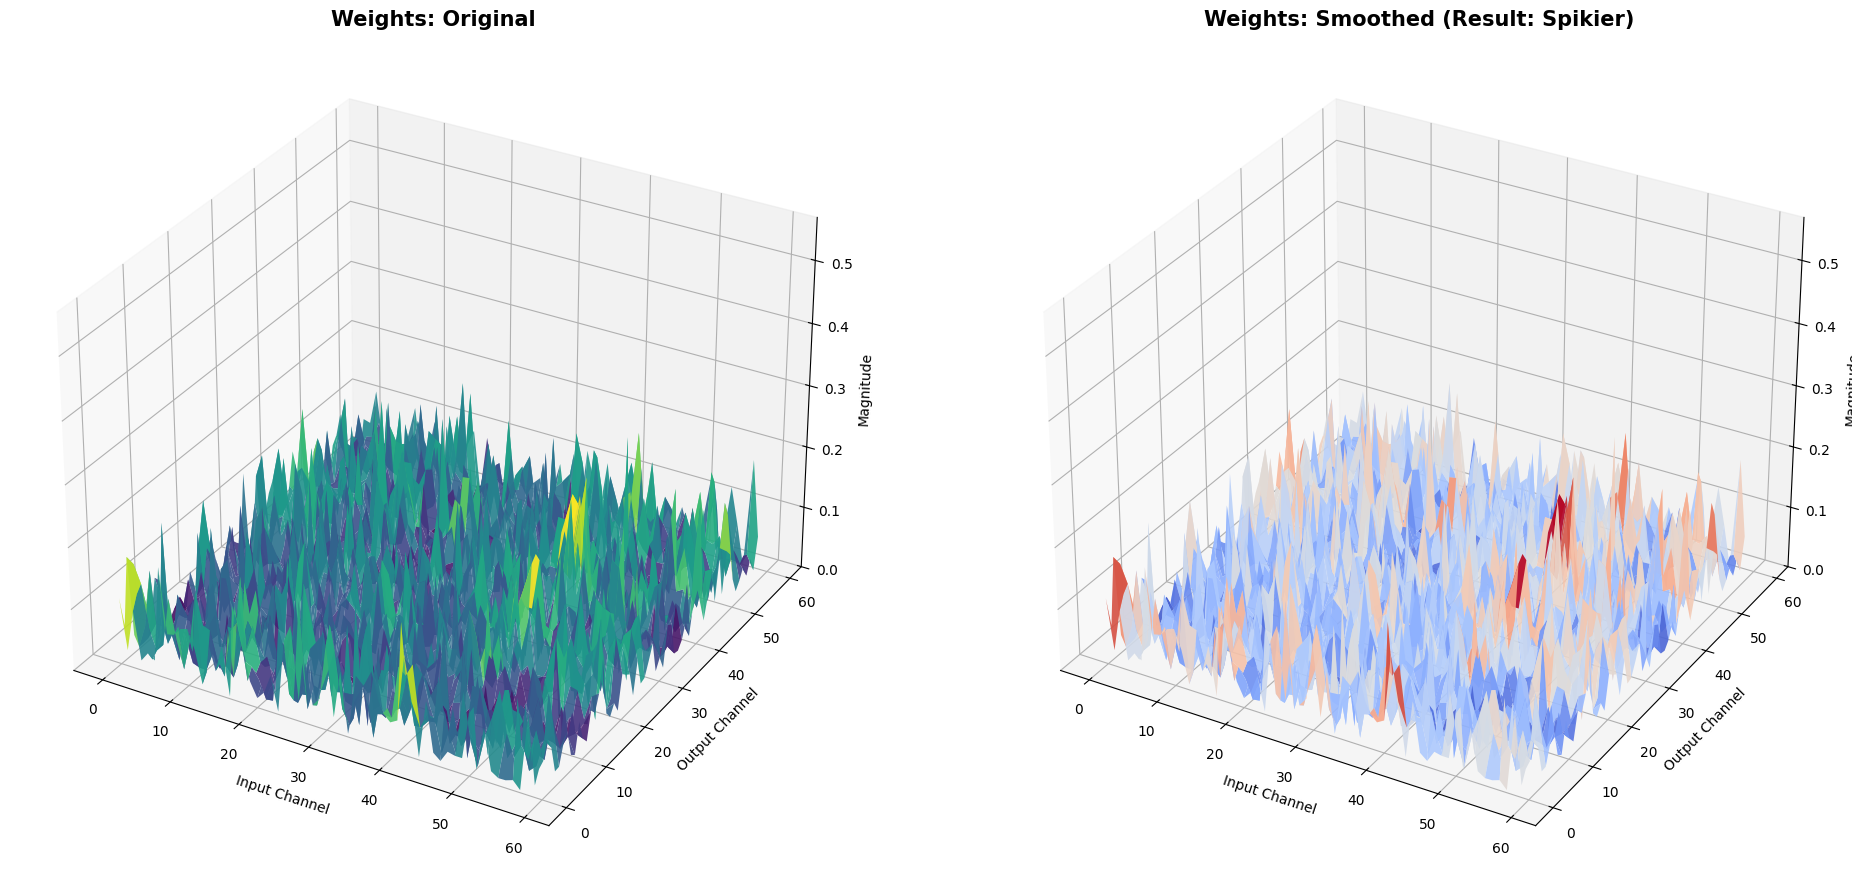


>>> PLOT: ACTIVATION BEFORE/AFTER
Activation Before Max: 6.85
Activation After Max:  6.85
(You should see the After Max is significantly smaller)


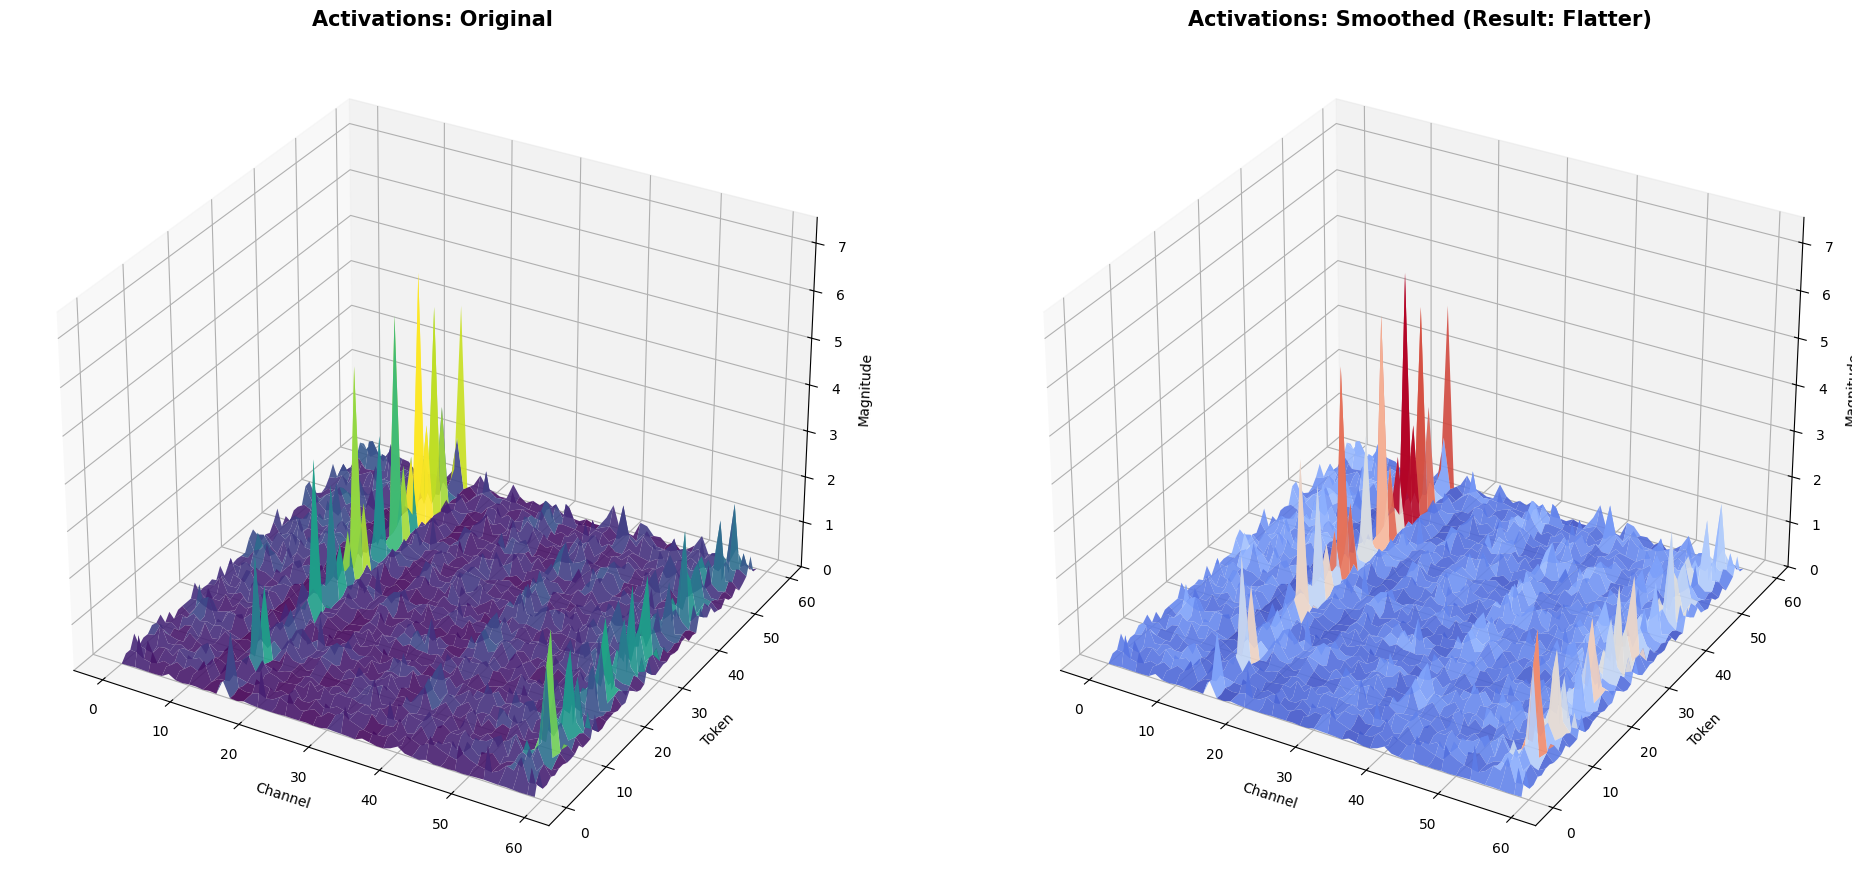

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch


def plot_smoothquant_effect_fixed_scale(data_before, data_after, title_prefix, xlabel='Channel', ylabel='Token', sample_rows=60, sample_cols=60):

    val_before = data_before.abs().detach().cpu().numpy()
    val_after = data_after.abs().detach().cpu().numpy()

    if val_before.ndim > 2: val_before = val_before[0]
    if val_after.ndim > 2: val_after = val_after[0]

    global_max = max(val_before.max(), val_after.max())
    z_limit = global_max * 1.1

    rows = min(val_before.shape[0], sample_rows)
    cols = min(val_before.shape[1], sample_cols)

    sub_before = val_before[:rows, :cols]
    sub_after = val_after[:rows, :cols]

    x = np.arange(cols)
    y = np.arange(rows)
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(20, 9))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, sub_before, cmap='viridis', edgecolor='none', alpha=0.9)
    ax1.set_title(f"{title_prefix}: Original", fontsize=15, fontweight='bold')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_zlabel('Magnitude')
    ax1.set_zlim(0, z_limit)
    ax1.view_init(elev=30, azim=-60)

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, sub_after, cmap='coolwarm', edgecolor='none', alpha=0.9)

    if "Weight" in title_prefix:
        desc = "Smoothed (Result: Spikier)"
    else:
        desc = "Smoothed (Result: Flatter)"

    ax2.set_title(f"{title_prefix}: {desc}", fontsize=15, fontweight='bold')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)
    ax2.set_zlabel('Magnitude')
    ax2.set_zlim(0, z_limit)
    ax2.view_init(elev=30, azim=-60)

    plt.tight_layout()
    plt.show()


# WEIGHTS: Original vs Smoothed
print(">>> PLOT: WEIGHT BEFORE/AFTER")

W_before = model.blocks[0].attn.qkv.weight.data
W_after  = smoothed_model.blocks[0].attn.qkv.weight.data

plot_smoothquant_effect_fixed_scale(
    W_before, W_after,
    "Weights",
    xlabel='Input Channel', ylabel='Output Channel'
)


# ACTIVATIONS: Original vs Smoothed
print("\n>>> PLOT: ACTIVATION BEFORE/AFTER")

# different from ActivationCollector
class DataCapturer:
    def __init__(self):
        self.data = None
        self.handle = None
    def hook_fn(self, m, i, o):
        self.data = i[0].detach().cpu() # Capture Activation
    def register(self, layer):
        self.handle = layer.register_forward_hook(self.hook_fn)
    def remove(self):
        if self.handle: self.handle.remove()


act_before = DataCapturer()
act_after = DataCapturer()

# Register
act_before.register(model.blocks[0].attn.qkv)
act_after.register(smoothed_model.blocks[0].attn.qkv)

device = next(model.parameters()).device
model.eval()
smoothed_model.eval()

with torch.no_grad():
    for img, _ in calibration_loader:
        img = img.to(device)
        model(img)          # Trigger act_before
        smoothed_model(img) # Trigger act_after
        break

act_before.remove()
act_after.remove()

if act_before.data is not None and act_after.data is not None:
    X_before = act_before.data[0]
    X_after  = act_after.data[0]

    print(f"Activation Before Max: {X_before.abs().max():.2f}")
    print(f"Activation After Max:  {X_after.abs().max():.2f}")
    print("(You should see the After Max is significantly smaller)")

    plot_smoothquant_effect_fixed_scale(
        X_before, X_after,
        "Activations",
        xlabel='Channel', ylabel='Token'
    )
else:
    print("Error: Failed to capture data.")
